<a href="https://colab.research.google.com/github/jvataidee/MachineLearning/blob/master/S%C3%A9ries_Temporais_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://static.wixstatic.com/media/bdd7cb_6ecb6c85550043f090237e5943d2647c~mv2.png/v1/fill/w_417,h_88,al_c,q_85,usm_0.66_1.00_0.01/Ativo%2023-8.webp)


#Previsão de Séries Temporais com o Prophet

Presente trabalho, iremos realizar a utilização do Prophet aplicado ao facebook.Desta forma, faremos a previsão relacionada ao desfecho de animais em um abrigo


##Modelo Preditivo do Prophet
O [Prophet](https://facebook.github.io/prophet/) é um *framework*   problemas do Facebook para lidar com séries temporais. Ou seja, é muito forte para lidar com problemas que tenham características como:

* Dados de longos períodos (meses ou anos), e que possuam o maior detalhamento histórico possível.
* Sazonalidades fortes e destacadas.
* Feriados ou datas especiais conhecidas *a priori*.
* Tendência de crescimento não linear, que se aproxima de um limite.

Propeht usa um modelo de séries temporais decomposto, com três componentes principais: tendência, sazonalidade e feriados:
 
$$
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
$$

onde:

* $g(t)$ é a tendência, que modela as mudanças não-periódicas no valor da série temporal;
* $s(t)$ representa as mudanças periódicas (como sazonalidade semanal, anual, etc);
* $h(t)$ representa os efeitos dos feriados;
* $\varepsilon_t$ é o erro, as mudanças que não são capturadas pelo modelo.


Mais sobre o Framework em [Clique Aqui](https://peerj.com/preprints/3190/).


#Aquisição de dados

Os dados foram disponibilizados pelo [Austin Animal Center](http://www.austintexas.gov/content/austin-animal-center) e podem ser baixados diretamente no [City of Austin Open Data Portal](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238). Esta instituição provem o  serviço publico de controle dos animais de rua ou os que se perderam dos seus donos, disponibilizando água, abrigo e apoio veterinário para os animais. 

Mediante a esse *dataset*  baixado em 30 de abril de 2020, que contém **117K linhas** e **12 colunas**. Podemos realaizar diversas manipulações e chegar em resultados bem interessantes, como veresmos.

In [ ]:
#Importação da Biblioteca
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# configurar a visualização
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [ ]:
#importação dos dados
dd = pd.read_csv("shelter_animal_outcomes.csv")

#converter em data time
dd.DateTime = pd.to_datetime(dd.DateTime)
dd.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,2019-05-08 18:20:00,05/08/2019 06:20:00 PM,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,2018-07-18 16:02:00,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A720371,Moose,2016-02-13 17:59:00,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
3,A674754,NaN,2014-03-18 11:47:00,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby
4,A689724,*Donatello,2014-10-18 18:52:00,10/18/2014 06:52:00 PM,08/01/2014,Adoption,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black


### Análise Exploratória

In [ ]:
#Estatística Descritiva
dd.describe()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
count,117416,80599,117416,117416,117416,117408,53247,117416,117413,117369,117416,117416
unique,104978,18867,96710,96710,6806,9,22,5,5,50,2568,585
top,A721033,Max,2016-04-18 00:00:00,04/18/2016 12:00:00 AM,09/01/2015,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,33,525,39,39,117,51722,29119,66777,41234,21150,30746,12337
first,NaN,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2020-04-30 18:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Resumo dos valores não nulos
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117416 entries, 0 to 117415
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Animal ID         117416 non-null  object        
 1   Name              80599 non-null   object        
 2   DateTime          117416 non-null  datetime64[ns]
 3   MonthYear         117416 non-null  object        
 4   Date of Birth     117416 non-null  object        
 5   Outcome Type      117408 non-null  object        
 6   Outcome Subtype   53247 non-null   object        
 7   Animal Type       117416 non-null  object        
 8   Sex upon Outcome  117413 non-null  object        
 9   Age upon Outcome  117369 non-null  object        
 10  Breed             117416 non-null  object        
 11  Color             117416 non-null  object        
dtypes: datetime64[ns](1), object(11)
memory usage: 10.7+ MB


In [ ]:
#verificando dados ausentes
dd.isnull().sum()

Animal ID               0
Name                36817
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type            8
Outcome Subtype     64169
Animal Type             0
Sex upon Outcome        3
Age upon Outcome       47
Breed                   0
Color                   0
dtype: int64

In [ ]:
#outcomes possíveis
dd['Outcome Type'].value_counts()

Adoption           51722
Transfer           34892
Return to Owner    20636
Euthanasia          7890
Died                1075
Rto-Adopt            611
Disposal             495
Missing               67
Relocate              20
Name: Outcome Type, dtype: int64

Com isso podemos ver que, 117416 destas datas em questão, 445 foram adotados, no entanto infelixmente 6.7% sofreram eutasasias. 

Contudo, iremos analisar dentre os animais que entraram na organização, quanto foram adotados ou retornaram aos seu donos.


In [ ]:
# Animas que foram adotados e retornaram aos donos
adoptions_dd = dd[(dd['Outcome Type'] == 'Adoption')]
adoptions_dd['outcomeCount'] = 1


o Prophet, só requer duas clunas,as entradas e a *DataTime*, desta forma sendo necessária criar um novo *DaraFrame* com estes

In [ ]:
adoptions_dd = adoptions_dd[['DateTime', 'outcomeCount']]
adoptions_dd = adoptions_dd.set_index('DateTime').sort_index()
adoptions_dd.head()

,outcomeCount
DateTime,
2013-10-01 09:31:00,1
2013-10-01 11:42:00,1
2013-10-01 11:53:00,1
2013-10-01 11:53:00,1
2013-10-01 15:47:00,1


In [ ]:
#Datas mínimas e máximas
adoptions_dd.index.min(), adoptions_dd.index.max()

(Timestamp('2013-10-01 09:31:00'), Timestamp('2020-04-30 14:41:00'))

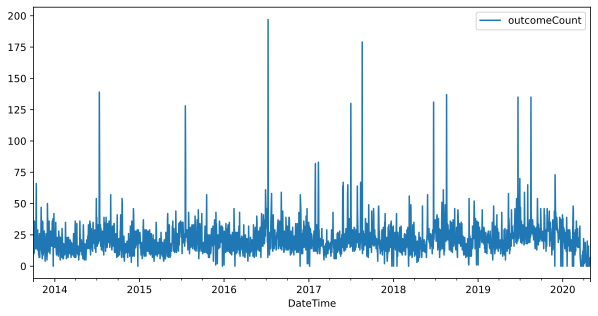

In [ ]:
#gráfico diário
fig, ax = plt.subplots(figsize=(10,5))
adoptions_dd.resample('D').sum().plot(ax = ax)
plt.show()

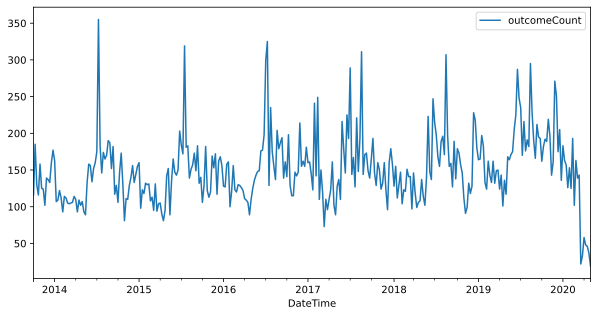

In [ ]:
#gráfico semanaris
fig, ax = plt.subplots(figsize=(10,5))
adoptions_dd.resample('W').sum().plot(ax=ax)
plt.show()

### Preparar os Dados para o Prophet

Para utilziad o Prophet, o *FrameWork*, somente necessida de douas colunas, a **ds** que é o tempo e **y** que é as somas das entradas e saídas dessa base de dados.


####Dados Diários

In [ ]:
# somando os dados diários
prophet_dd = adoptions_dd.resample('D').sum().reset_index().rename(columns={
    'DateTime':'ds', 'outcomeCount':'y'})
prophet_dd.head()

,ds,y
0,2013-10-01,11
1,2013-10-02,16
2,2013-10-03,10
3,2013-10-04,11
4,2013-10-05,36


##### Modelo de Forecasting

In [ ]:
#adicionando datas de feriados nacionais do Estado Unidos
modelo1 = Prophet()
modelo1.add_country_holidays(country_name = "US")
modelo1.fit(prophet_dd)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#Determinando o periodo de previsão, para um ano
val_fut =  modelo1.make_future_dataframe(periods = 365)

In [ ]:
#Previsões
forest = modelo1.predict(val_fut)

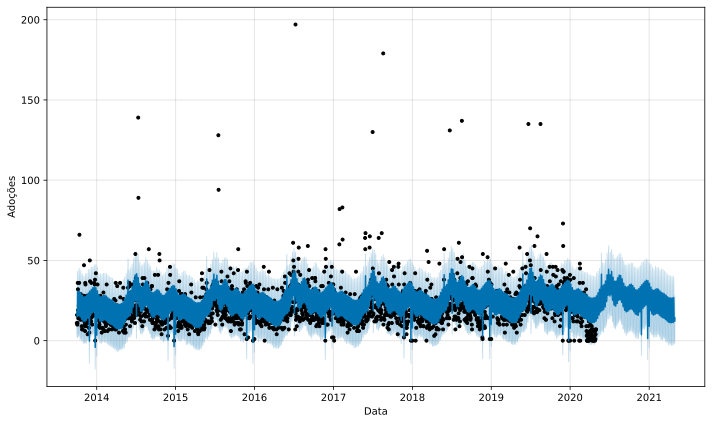

In [ ]:
#Visualizando as previsões
modelo1.plot(forest, xlabel = "Data", ylabel = "Adoções");

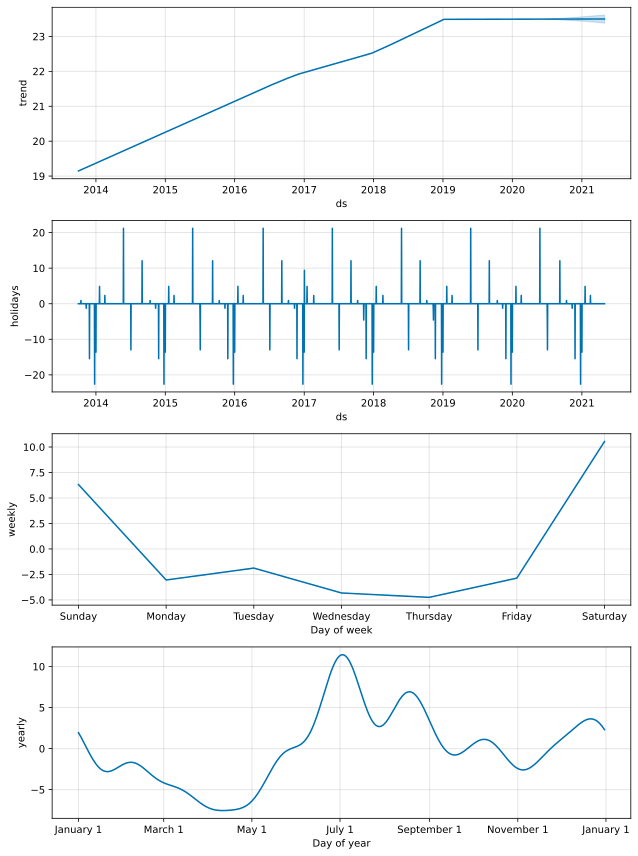

In [ ]:
modelo1.plot_components(forest);

####Dados Semanais

In [ ]:
#somando os dados semanais
modelo2 = adoptions_dd.resample('W').sum().reset_index().rename(columns={
    'DateTime':'ds', 'outcomeCount':'y'})

##### Modelo de Forecasting

In [ ]:
#adicionando datas de feriados nacionais do Estado Unidos
modelo2 = Prophet()
modelo2.add_country_holidays(country_name = "US")
modelo2.fit(prophet_dd)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#determinar o periodo
val_fut2 =  modelo2.make_future_dataframe(periods = 52)

In [ ]:
# realizar a previsão para o período
forest2 = modelo2.predict(val_fut2)

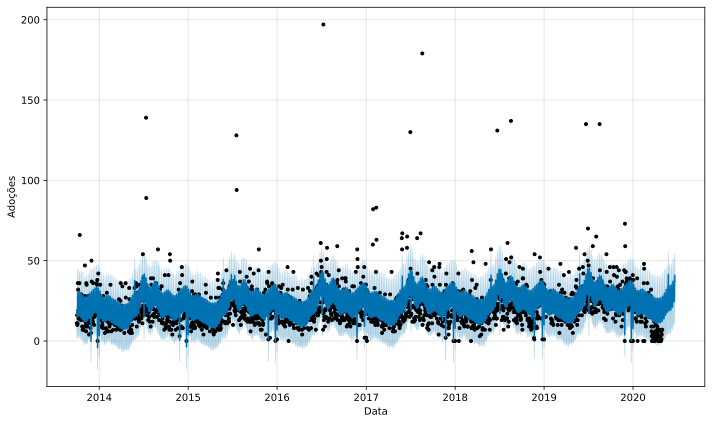

In [ ]:
# visualizar o gráfico com as previsões
modelo2.plot(forest2, xlabel='Data', ylabel='Adoções');

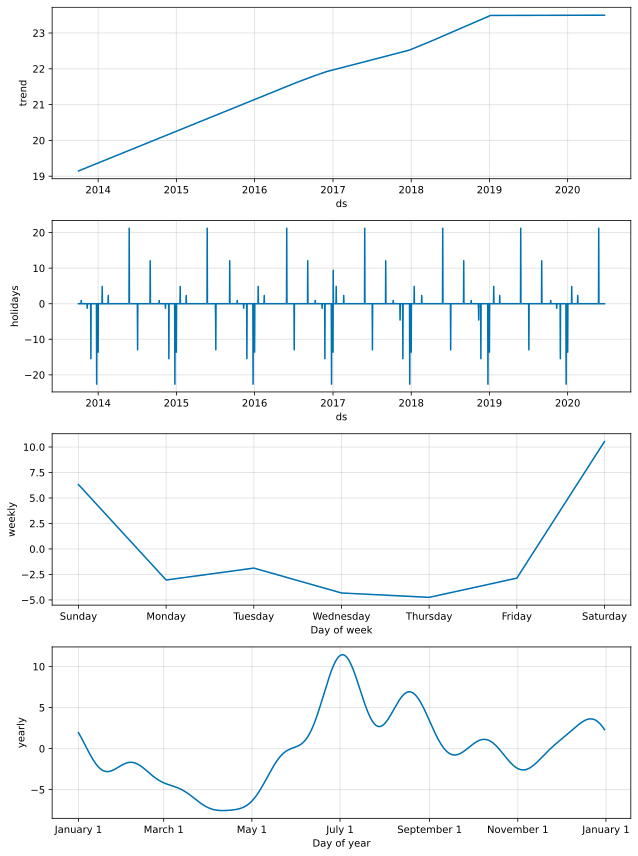

In [ ]:
# separar os componentes do modelo
modelo2.plot_components(forest2);

### Avaliação dos Modelos


####Dados Diários

##### Validação Cruzada


In [ ]:
from fbprophet.diagnostics import cross_validation
df_cross = cross_validation(modelo1, horizon = '365 days')
df_cross.head()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2016-10-30 12:00:00 and 2019-05-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-10-31,15.595742,3.356098,27.182709,16,2016-10-30 12:00:00
1,2016-11-01,16.120902,4.148256,28.725243,16,2016-10-30 12:00:00
2,2016-11-02,14.068885,1.984653,25.498470,13,2016-10-30 12:00:00
3,2016-11-03,13.692068,1.833686,25.699377,21,2016-10-30 12:00:00
4,2016-11-04,14.611005,2.853651,26.919730,26,2016-10-30 12:00:00


#####Metricas de performance


In [ ]:
from fbprophet.diagnostics import performance_metrics
df_per = performance_metrics(df_cross)
df_per.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,36 days 12:00:00,96.537963,9.825373,7.186419,0.262747,0.858447
1,37 days 00:00:00,96.422144,9.819478,7.172768,0.262747,0.858447
2,37 days 12:00:00,97.372306,9.867741,7.265063,0.268853,0.858447
3,38 days 00:00:00,96.863575,9.841929,7.246640,0.269114,0.858447
4,38 days 12:00:00,96.506757,9.823785,7.218155,0.268853,0.863014


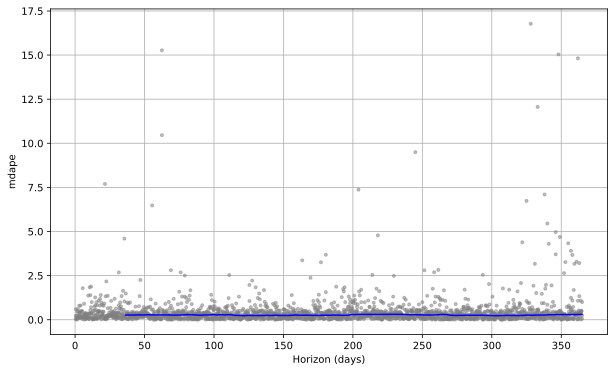

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
figura = plot_cross_validation_metric(df_cross, metric='mdape')

####Dados Semanais


##### Validação Cruzada


In [ ]:
df_cross2 = cross_validation(modelo2, horizon = '365 days')
df_cross2.head()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2016-10-30 12:00:00 and 2019-05-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-10-31,15.595742,2.984438,27.270178,16,2016-10-30 12:00:00
1,2016-11-01,16.120902,4.142163,27.308199,16,2016-10-30 12:00:00
2,2016-11-02,14.068885,1.687266,24.864342,13,2016-10-30 12:00:00
3,2016-11-03,13.692068,1.367335,24.736610,21,2016-10-30 12:00:00
4,2016-11-04,14.611005,3.616050,28.060690,26,2016-10-30 12:00:00


#####Metricas de performance


In [ ]:
df_per2 = performance_metrics(df_cross)
df_per2.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,36 days 12:00:00,96.537963,9.825373,7.186419,0.262747,0.858447
1,37 days 00:00:00,96.422144,9.819478,7.172768,0.262747,0.858447
2,37 days 12:00:00,97.372306,9.867741,7.265063,0.268853,0.858447
3,38 days 00:00:00,96.863575,9.841929,7.246640,0.269114,0.858447
4,38 days 12:00:00,96.506757,9.823785,7.218155,0.268853,0.863014


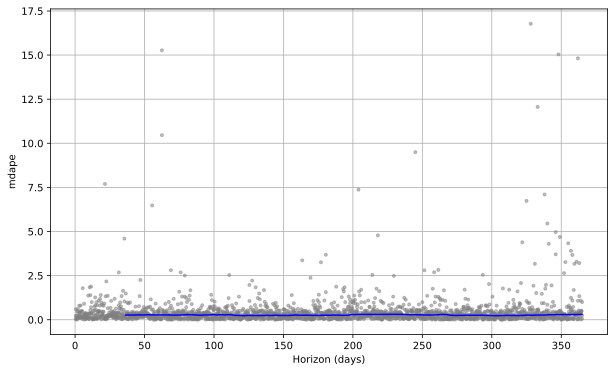

In [ ]:
figura2 = plot_cross_validation_metric(df_cross2, metric = 'mdape')